# Constructing Canonical Forcing Fields

In [134]:
# data handling
import numpy as np
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cmocean

# helper functions
import utils

## Introduction

This notebook will cover the synthesizing of the following forcing fields:
1) A homogeneous current field,
2) A zonal current jet,
3) A mesoscale eddy,
4) A constant bathymetry field,
5) and an idealized island.

With bonus files for a sloped beach.

All fields will be steady (no variation in time), a core assumption of the ray tracing equations.

In [135]:
output_dir = "./forcing/"

## Domain Parameters

For these synthesized datasets, we will be using a 100 km by 200 km domain with 1 km grid spacing. Mantaray expects the grid to be in units of meters.

In [136]:
# Parameters for the background domain [m]
Lx = 200_000  # x-length
Ly = 100_000  # y-length
dx = 1_000  # x grid spacing
dy = 1_000  # y grid spacing

In [137]:
# x/y grid
x = np.arange(0, Lx, dx)
y = np.arange(0, Ly, dy)
xv, yv = np.meshgrid(x, y)

## Currents

### No Currents

This field will have the same u/v velocity (0 m/s) at all grid points and will be used for examples where we are interested in studying how the waves respond to different depth fields.

In [138]:
# Choose a u/v current speed [m/s]
u = 0
v = 0

In [139]:
# grid u/v
U_homog = np.full_like(xv, u)
V_homog = np.full_like(yv, v)

In [140]:
# build into an xarray dataset
ds_homog = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (
            ["y", "x"],
            U_homog,
            {"long_name": "zonal current velocity", "units": "m/s"},
        ),
        "v": (
            ["y", "x"],
            V_homog,
            {"long_name": "meridional current velocity", "units": "m/s"},
        ),
    }
)

Note: data must be saved using the `NETCDF3_CLASSIC` format.

In [141]:
ds_homog.to_netcdf(output_dir + "homogeneous.nc", format="NETCDF3_CLASSIC")

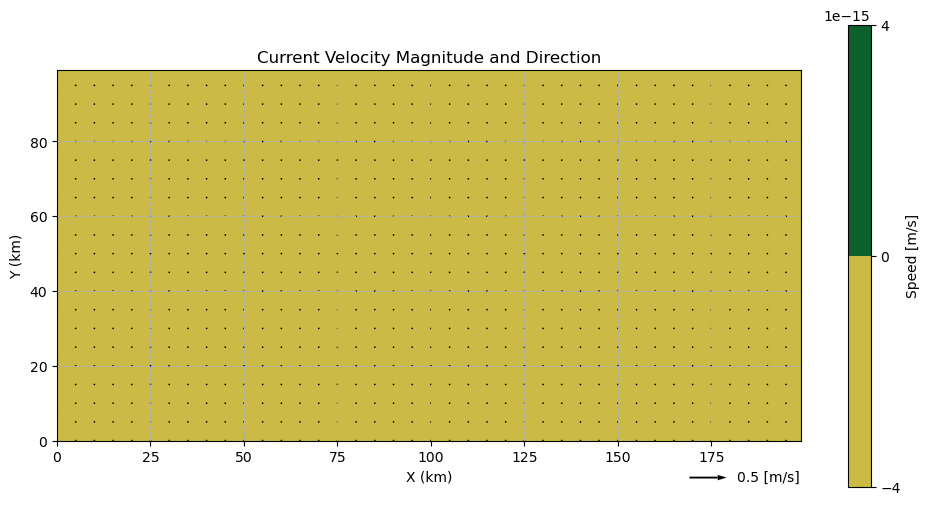

In [142]:
# Plot using helper function
utils.plot_current_field(xv, yv, ds_homog, skip=5, q_scale=0.1)

### Zonal Jet

This field will have a zonal current jet whose profile follows a Gaussian distribution:
$$
f(x) = A \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

In [143]:
# Choose the maximum speed of the jet [m/s]
U_max = 0.3
width = 0.25  # controls how 'fat' the distribution (jet) is

In [144]:
x_profile = np.linspace(-1, 1, len(y))
U_profile = U_max * np.exp((-(x_profile**2)) / (2 * width**2))

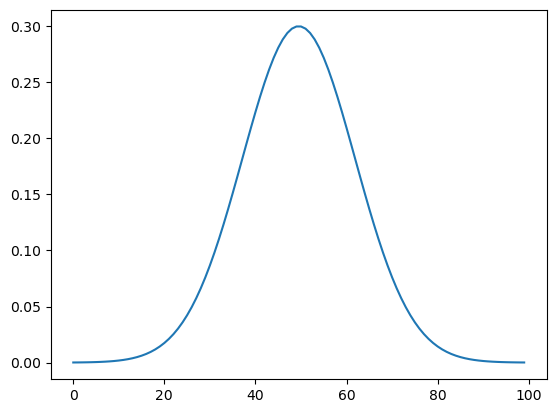

In [145]:
plt.plot(U_profile)

We extend the profile along the x-axis and assume there is no zonal current.

In [146]:
U_jet = np.ones((len(y), len(x))) * U_profile[:, np.newaxis]
V_jet = np.zeros_like(U_jet)

In [147]:
ds_jet = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (
            ["y", "x"],
            U_jet,
            {"long_name": "zonal current velocity", "units": "m/s"},
        ),
        "v": (
            ["y", "x"],
            V_jet,
            {"long_name": "meridional current velocity", "units": "m/s"},
        ),
    }
)

In [148]:
ds_jet.to_netcdf(output_dir + "zonal_jet.nc", format="NETCDF3_CLASSIC")

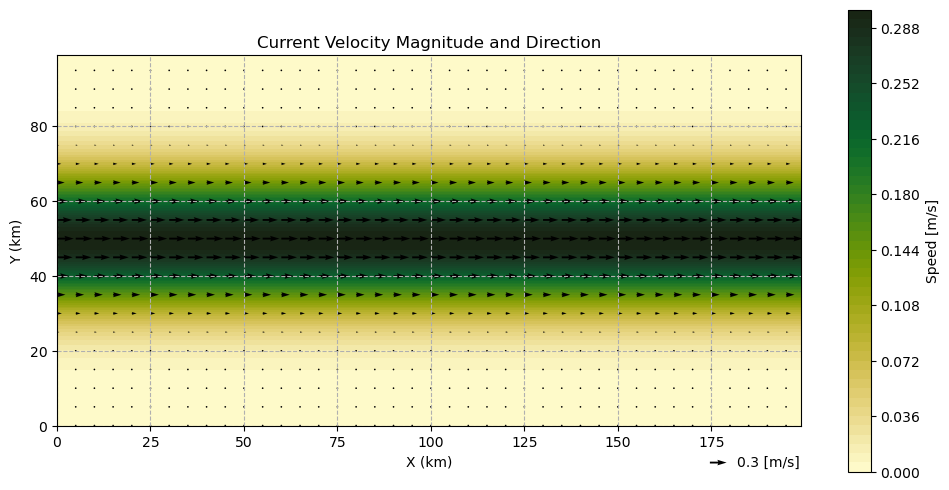

In [149]:
utils.plot_current_field(xv, yv, ds_jet, skip=5, q_ref=0.3, q_scale=0.075)

### Mesoscale Eddy

We will construct a idealized parabolic mesoscale eddy following White and Fornberg 1997.

In [150]:
L_eddy = 80_000  # Diameter of the eddy [m]

In [151]:
R_eddy = L_eddy / 2

The number of grid points must be odd to ensure that the eddy is properly centered.

In [152]:
N = int(L_eddy / dx) + 1

Similar to our full domain, we make a smaller domain for the eddy.

In [153]:
# Create 2D grid
x_eddy = np.linspace(-R_eddy, R_eddy, N)
y_eddy = np.linspace(-R_eddy, R_eddy, N)

xv_eddy, yv_eddy = np.meshgrid(x_eddy, y_eddy)

We set the maximum speed of the Eddy to be 1 m/s to make it's impact on rays more dramatic.

In [154]:
U_max = 1.0  # [m/s]

We will use a custom function to create a velocity field for a parabolic eddy as in White and Fornberg 1997.

In [155]:
u_eddy, v_eddy = utils.generate_parabolic_ring_eddy(L_eddy, U_max, xv_eddy, yv_eddy)

We now insert the eddy into a larger domain. We define the center of the eddy using the units of the domain.

In [156]:
# Define the center of the eddy [m]
center_x = 100_000
center_y = 50_000

Then, we can create a static background, find the indices of the center point, and insert the eddy.

In [157]:
# Create static background velocity field
u_background = np.zeros_like(xv).astype(float)
v_background = np.zeros_like(yv).astype(float)

idx_center_x = int((center_x - L_eddy / 2) / dx)
idx_center_y = int((center_y - L_eddy / 2) / dy)

# Insert the tapered eddy
u_background[
    idx_center_y : idx_center_y + len(x_eddy), idx_center_x : idx_center_x + len(x_eddy)
] += u_eddy
v_background[
    idx_center_y : idx_center_y + len(x_eddy), idx_center_x : idx_center_x + len(x_eddy)
] += v_eddy

In [158]:
ds_eddy = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (
            ["y", "x"],
            u_background,
            {"long_name": "zonal current velocity", "units": "m/s"},
        ),
        "v": (
            ["y", "x"],
            v_background,
            {"long_name": "meridional current velocity", "units": "m/s"},
        ),
    }
)

In [159]:
ds_eddy.to_netcdf(output_dir + "mesoscale_eddy.nc", format="NETCDF3_CLASSIC")

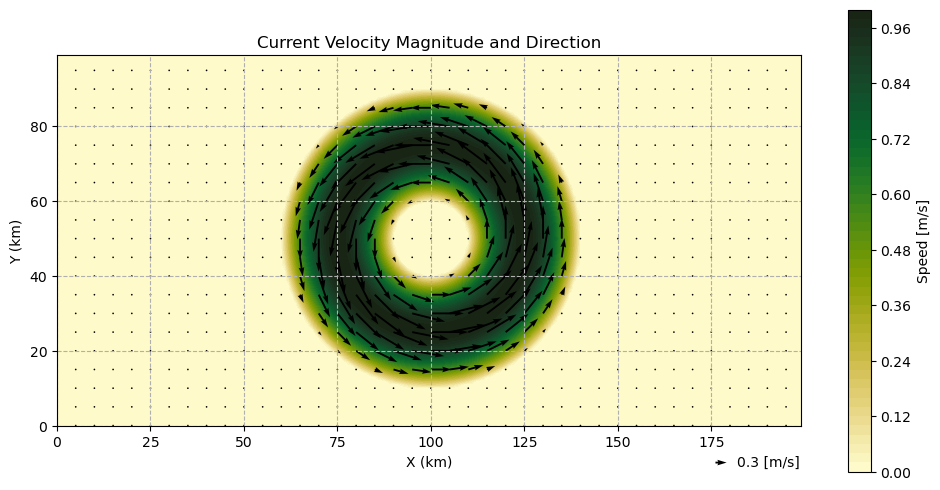

In [160]:
utils.plot_current_field(xv, yv, ds_eddy, skip=5, q_ref=0.3, q_scale=0.05)

### Constant Bathymetry

For the different current examples, we will use a constant deep bathymetry field.

In [161]:
bathy_const = np.full_like(xv, 4000)  # [m]

In [162]:
ds_const = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_const, {"long_name": "bathymetry", "units": "m"}),
    }
)

In [163]:
ds_const.to_netcdf(output_dir + "4000m_bathymetry.nc", format="NETCDF3_CLASSIC")

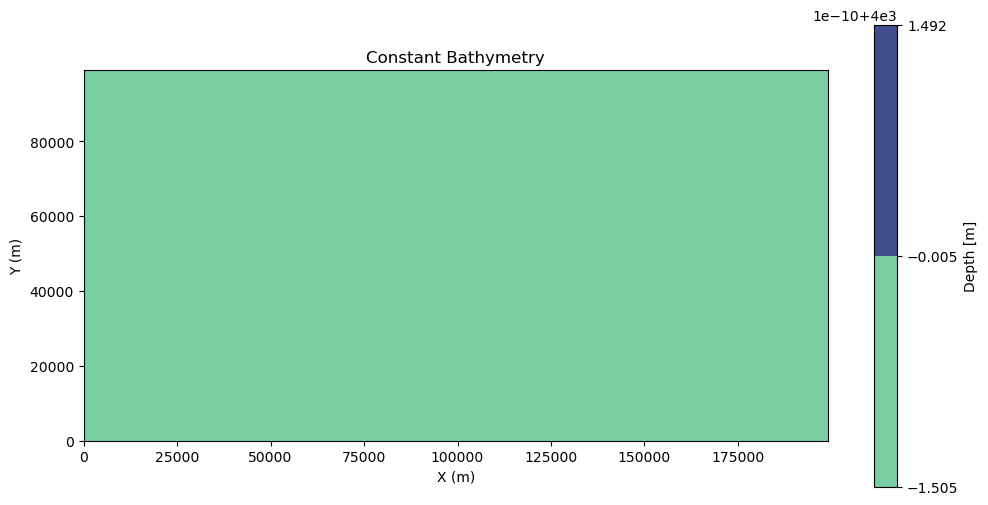

In [164]:
fig, ax = plt.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_const, cmap=cmocean.cm.deep)

fig.colorbar(c, ax=ax, label="Depth [m]")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.set_title("Constant Bathymetry")

ax.set_aspect("equal")

plt.show()

## Gaussian Island

We will also show an example of no currents but with an island sea mound.

In [165]:
# Island parameters [m]
L_mound = 1e5  # diameter of the sea mound
H_background = 100  # background depth
elevation = 50  # maximum height of the island (above sea level)

In [166]:
x_mound = np.arange(
    -L_mound / 2, L_mound / 2, dx
)  # x-axis values (symmetrical about 0)
y_mound = np.arange(
    -L_mound / 2, L_mound / 2, dy
)  # y-axis values (symmetrical about 0)
xv_mound, yv_mound = np.meshgrid(x_mound, y_mound)

In [167]:
R = np.sqrt(xv_mound**2 + yv_mound**2)

# Normalize the radial distance to range from 0 to L_x/2 (maximum radial distance)
R_normalized = np.clip(R / (L_mound / 2), 0, 1)  # Normalize radius, clip to [0, 1]

# Use sin^2 function to create the profile, with peak at sin^2(pi/2)
mound = (H_background + elevation) * np.sin(np.pi * R_normalized / 2 + np.pi / 2) ** 2

In [168]:
# Define island center in the larger bathymetry field
center_x = 100000  # meters
center_y = 50000  # meters

In [169]:
idx_center_x = int((center_x - L_mound / 2) / dx)
idx_center_y = int((center_y - L_mound / 2) / dy)

bathy_const = np.full_like(xv, H_background).astype(float)

# Subtract the island bump from the bathymetry field
bathy_island = bathy_const.copy()
bathy_island[
    idx_center_y : idx_center_y + len(y_mound),
    idx_center_x : idx_center_x + len(x_mound),
] -= mound

In [170]:
ds_island = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_island, {"long_name": "bathymetry", "units": "m"}),
    }
)

In [171]:
ds_island.to_netcdf(output_dir + "gaussian_island.nc", format="NETCDF3_CLASSIC")

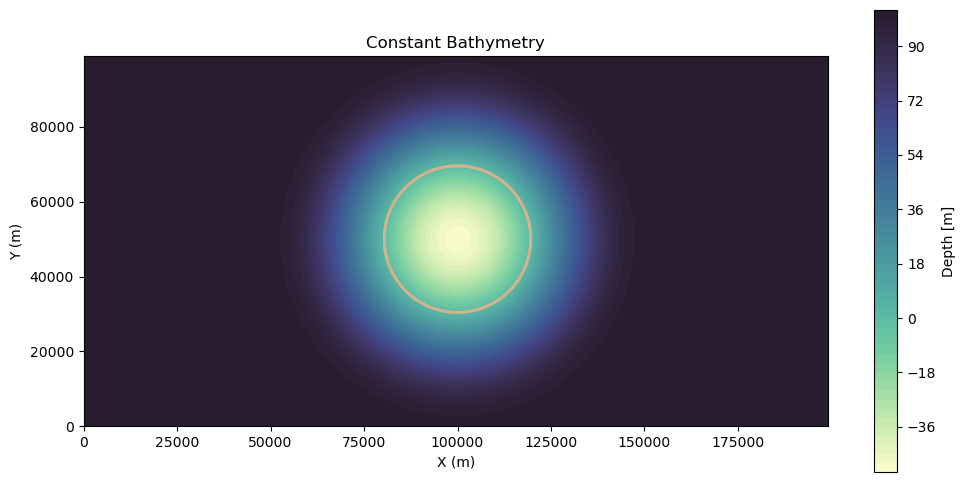

In [172]:
fig, ax = plt.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_island, cmap=cmocean.cm.deep, levels=50)

is_contour = ax.contour(xv, yv, bathy_island, levels=[0], colors="tan", linewidths=2)
is_contour = ax.contour(xv, yv, bathy_island, levels=[0], colors="tan", linewidths=2)


fig.colorbar(c, ax=ax, label="Depth [m]")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.set_title("Constant Bathymetry")

ax.set_aspect("equal")

plt.show()

Note: following convention, more positive depth is deeper, while more negative depth is above sea level.

### BONUS: A Gentle Beach

We will construct a bathymetry field that linearly increases in depth along the y-axis.

In [173]:
bathy_beach = np.tile(
    np.linspace(250, -10, yv.shape[0])[:, np.newaxis], (1, yv.shape[1])
)

In [174]:
ds_beach = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_beach, {"long_name": "bathymetry", "units": "m"}),
    }
)

In [175]:
ds_beach.to_netcdf(output_dir + "gentle_slope.nc", format="NETCDF3_CLASSIC")

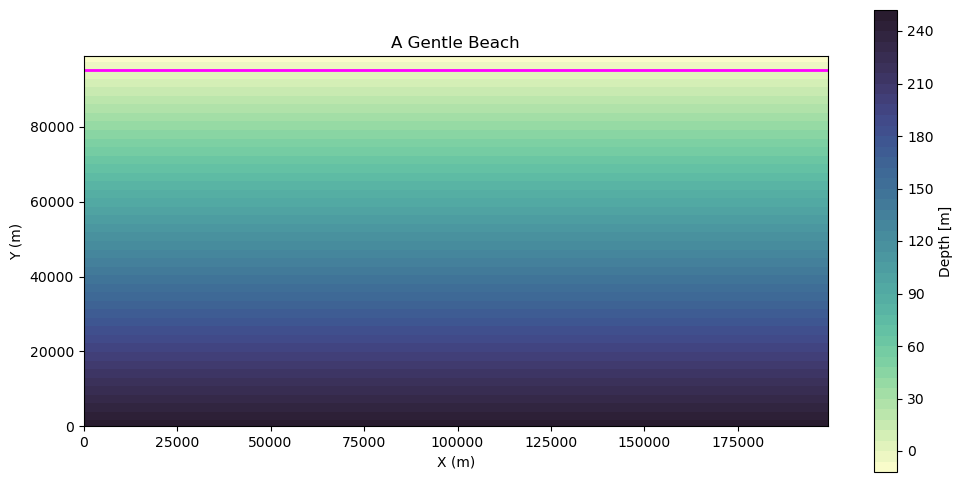

In [176]:
fig, ax = plt.subplots(figsize=(12, 6))

# Filled contour plot
c = ax.contourf(xv, yv, bathy_beach, cmap=cmocean.cm.deep, levels=50)

# Add contour line at 0 depth
zero_contour = ax.contour(
    xv, yv, bathy_beach, levels=[0], colors="magenta", linewidths=2
)

fig.colorbar(c, ax=ax, label="Depth [m]")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("A Gentle Beach")

ax.set_aspect("equal")

plt.show()